### Installing all the libraries needed for this project

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.ensemble import RandomForestClassifier
import string
import re
from nltk.corpus import stopwords

## Step: 1 Loading the Dataset

The dataset is available at https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.The dataset contains more than 5 thousand SMS phone messages

In [41]:
# list of all the lines of text messages.
page = open('SMSSpamCollection')
mess = [line.rstrip() for line in page]
print len(mess)
print mess[5]

5574
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


In [42]:
#Printing top 7 messages with the message number(index)
for index, message in enumerate(mess[:7]):
    print index, message

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


In [43]:
# Reading the dataset into a dataframe mess and displaying the top 5 rows and the dimension of the mess dataframe
mess = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])
print mess.head()
print mess.shape

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)


## Step 2 : Data Exploration

In [44]:
#Checking for the counts and percentage based on the label
print mess.label.value_counts()
print mess.label.value_counts()/len(mess)

ham     4825
spam     747
Name: label, dtype: int64
ham     0.865937
spam    0.134063
Name: label, dtype: float64


We can notice that the dataset is highly imbalanced dataset with 4825 ham messages and just 747 spam messages meaning 87% of the dataset belongs to ham messages and just 13% belongs to the spam class.

In [45]:
# Creating a new feature "len" which tells the lenth of the text messages
mess['len'] = mess['message'].map(lambda x: len(x))
print mess.head()
print mess.info()

  label                                            message  len
0   ham  Go until jurong point, crazy.. Available only ...  111
1   ham                      Ok lar... Joking wif u oni...   29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...  155
3   ham  U dun say so early hor... U c already then say...   49
4   ham  Nah I don't think he goes to usf, he lives aro...   61
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
label      5572 non-null object
message    5572 non-null object
len        5572 non-null int64
dtypes: int64(1), object(2)
memory usage: 130.7+ KB
None


In [46]:
mess['len'].describe()

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: len, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000104102B0>]], dtype=object)

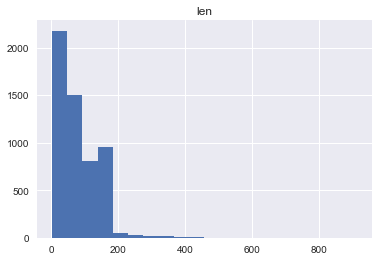

In [47]:
#Lets visualize the distribution of the lenth of the text messages
mess.hist(column='len',bins=20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010AC7D68>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000010AEEBA8>], dtype=object)

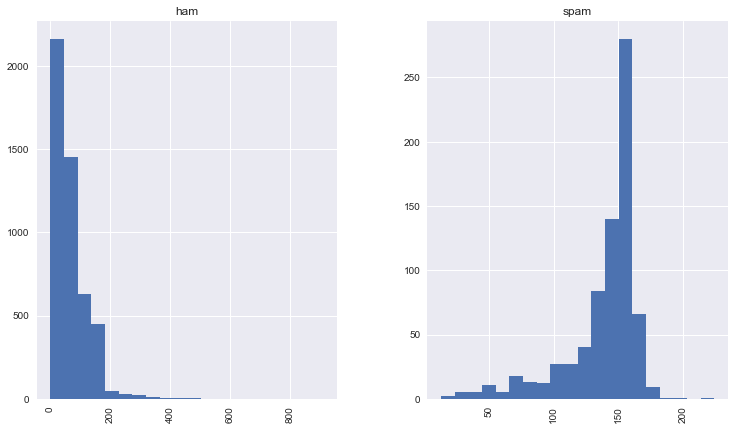

In [48]:
#Visualization of the lenth across label
mess.hist(column='len', by='label', bins=20, figsize=(12,7))

Based on the above visualization it is clear that ham messages tends to be shorter and spam messages are of longer length.

## Step 3 : Data Cleaning and Text preprocessing

In [49]:
# impoting a list of english stopwords from NLTK library
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhavy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
#Creating a function called text_process which will remove the non letters, punctuation, and stop words
def text_process(mess):

    # Remove non-letters        
    letters = re.sub("[^a-zA-Z]", " ", mess)
    
    # Remove punctuation
    nopunc = [char for char in letters if char not in string.punctuation]

    # Join the characters
    nopunc = ''.join(nopunc)
    
    # Rremove stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [51]:
#Checking if the function defined above is working fine
clean_words = text_process(mess['message'][10] )
print clean_words

['gonna', 'home', 'soon', 'want', 'talk', 'stuff', 'anymore', 'tonight', 'k', 'cried', 'enough', 'today']


In [52]:
#Applying the function on the mess dataframe
mess['message'].apply(text_process)

0       [Go, jurong, point, crazy, Available, bugis, n...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, wkly, comp, win, FA, Cup, final,...
3           [U, dun, say, early, hor, U, c, already, say]
4          [Nah, think, goes, usf, lives, around, though]
5       [FreeMsg, Hey, darling, week, word, back, like...
6       [Even, brother, like, speak, treat, like, aids...
7       [per, request, Melle, Melle, Oru, Minnaminungi...
8       [WINNER, valued, network, customer, selected, ...
9       [mobile, months, U, R, entitled, Update, lates...
10      [gonna, home, soon, want, talk, stuff, anymore...
11      [SIX, chances, win, CASH, pounds, txt, CSH, se...
12      [URGENT, week, FREE, membership, Prize, Jackpo...
13      [searching, right, words, thank, breather, pro...
14                                         [DATE, SUNDAY]
15      [XXXMobileMovieClub, use, credit, click, WAP, ...
16                                      [Oh, k, watching]
17      [Eh, u

## Step 4 : Vectorization

Now its time to convert each  messages into a vector that the SciKit Learn's algorithm models can work with.
We'll follow the below three steps to do that using the bag-of-words model:

 * Count how many times does a word occur in each message (Known as term frequency)
 * Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
 * Normalize the vectors to unit length, to abstract from the original text length (L2 norm)
 
The Bag of Words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. For example, consider the following two sentences:
 * Sentence 1: "The cat sat on the hat"
 * Sentence 2: "The dog ate the cat and the hat"

From these two sentences, our vocabulary is as follows: { the, cat, sat, on, hat, dog, ate, and }
To get our bags of words, we count the number of times each word occurs in each sentence. In Sentence 1, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for Sentence 1 is: { the, cat, sat, on, hat, dog, ate, and }
 * Sentence 1: { 2, 1, 1, 1, 1, 0, 0, 0 }
 * Similarly, the features for Sentence 2 are: { 3, 1, 0, 0, 1, 1, 1, 1}

In [53]:
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool
# fit_transform() does two functions: First, it fits the model and learns the vocabulary
# second, it transforms our data into vectors.

cv= CountVectorizer(analyzer=text_process)
cv_transform = cv.fit_transform(mess['message'])
cv_transform.shape

(5572, 9624)

In [54]:
message10 = mess['message'][9]
print message10
transformed_10 = cv.transform([message10])
print transformed_10

Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
  (0, 464)	1
  (0, 531)	1
  (0, 905)	1
  (0, 982)	1
  (0, 1822)	1
  (0, 2251)	1
  (0, 2946)	1
  (0, 3003)	2
  (0, 4086)	1
  (0, 4357)	1
  (0, 5033)	1
  (0, 6296)	1
  (0, 6746)	1
  (0, 6747)	1
  (0, 6777)	1


In [55]:
print cv.get_feature_names()[905]
print cv.get_feature_names()[3003]

FREE
Update


In [56]:
vocab = cv.get_feature_names()
print vocab
print len(vocab)

['ABOUTAS', 'ABTA', 'ACCEPT', 'ACL', 'ACTION', 'ACTUALLY', 'AD', 'ADAM', 'ADDAMSFA', 'ADP', 'ADRINK', 'AE', 'AFEW', 'AFTERNOON', 'AG', 'AGE', 'AGES', 'AGO', 'AH', 'AIG', 'AINT', 'AJ', 'AL', 'ALERT', 'ALETTER', 'ALEX', 'ALRITE', 'ALSO', 'ALWAYS', 'AMY', 'ANAL', 'ANNIE', 'ANS', 'ANSWER', 'ANTELOPE', 'ANYTHING', 'ANYWAY', 'AOM', 'APPY', 'APRIL', 'AQ', 'AREA', 'ARIES', 'AROUND', 'ARR', 'ASAP', 'ASJESUS', 'ASKED', 'ASLEEP', 'ASTHERE', 'ASUSUAL', 'ATM', 'AUCTION', 'AUGUST', 'AV', 'AVA', 'AVE', 'AVENT', 'AWAITING', 'AWARD', 'AXEL', 'AXIS', 'Aah', 'Aaniye', 'Aaooooright', 'Ab', 'Abbey', 'Abeg', 'Aberdeen', 'Abiola', 'Abt', 'Accept', 'Accident', 'AccommodationVouchers', 'Account', 'Accounts', 'Ache', 'Acnt', 'Aco', 'Activate', 'Active', 'Actually', 'Address', 'Admirer', 'Adrian', 'Adult', 'Aeronautics', 'Affections', 'Aft', 'AfterNoon', 'Afternoon', 'Afternoons', 'Aftr', 'Agalla', 'Age', 'Ages', 'Ah', 'Ahhh', 'Ahhhh', 'Ahmad', 'Aight', 'Air', 'Airtel', 'Aiya', 'Aiyah', 'Aiyar', 'Aiyo', 'Aka', '

And finally, after the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer

TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

See below for a simple example.

Example:

Consider a document containing 100 words wherein the word cat appears 3 times.

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

In [57]:
messages_tfidf = TfidfTransformer().fit(cv_transform).transform(cv_transform)
print messages_tfidf.shape
print messages_tfidf

(5572, 9624)
  (0, 1096)	0.242903771884
  (0, 6152)	0.313654438828
  (0, 7397)	0.247928569616
  (0, 4522)	0.250739163919
  (0, 182)	0.289315488112
  (0, 4021)	0.269665316453
  (0, 6861)	0.168173717353
  (0, 5615)	0.18283161901
  (0, 9500)	0.224966802608
  (0, 6252)	0.264976537395
  (0, 4920)	0.185013294707
  (0, 4020)	0.299417065352
  (0, 522)	0.313654438828
  (0, 5584)	0.151774819505
  (0, 3478)	0.313654438828
  (0, 9328)	0.188813072269
  (1, 2003)	0.290179104656
  (1, 6284)	0.377054701026
  (1, 1453)	0.562458096388
  (1, 9418)	0.400950140825
  (1, 9087)	0.204257935032
  (1, 7085)	0.504761735883
  (2, 982)	0.167268596465
  (2, 5036)	0.382596158394
  (2, 9465)	0.2100939169
  :	:
  (5567, 2188)	0.340845576247
  (5568, 5810)	0.332016511069
  (5568, 3698)	0.386332677633
  (5568, 5565)	0.337213441366
  (5568, 5390)	0.515168521674
  (5568, 5063)	0.601166023499
  (5569, 6778)	0.506896891827
  (5569, 2160)	0.609530778983
  (5569, 8632)	0.609530778983
  (5570, 9366)	0.209466203718
  (5570, 637

## Step : 5 Training & Evaluating a Model

Here in this step we will build the model using different classifier.For applying any machine learning model we first split the dataset into training and test dataset so that a model can be built using the training dataset and we can check the performance of the classifier/model using the unseen/test dataset.We should never actually evaluate the performance on the same dataset we used to train our model.So I'll put 30% data for the validation purpose which I'll never used in any way.

In [58]:
features = mess['message']
target = mess['label']

In [59]:
features_train, features_test, label_train, label_test = train_test_split(features, target, test_size=0.3)
print len(features_train), len(features_test), len(features_train) + len(features_test)

3900 1672 5572


Here we will use SciKit Learn's pipeline capabilities to store a pipline of workflow.Pipeline class is a useful tool for encapsulating multiple different transformers alongside an estimator into one object, so that you only have to call your important methods once (fit(), predict(), etc)

### Naive Bayes Classifier

In [60]:
#Naive Bayes Classifier
pipeline_NB = Pipeline([
    ('CV', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [61]:
Model_NB = pipeline_NB.fit(features_train,label_train)
Pred_NB = Model_NB.predict(features_test)
print classification_report(Pred_NB,label_test)

             precision    recall  f1-score   support

        ham       1.00      0.97      0.98      1493
       spam       0.77      1.00      0.87       179

avg / total       0.98      0.97      0.97      1672



In [64]:
pd.crosstab(label_test, Pred_NB, rownames=['Actual'], colnames=['Predicted'])

Predicted,ham,spam
Actual,,
ham,1441,0
spam,52,179


In [65]:
pred_prob_NB = Model_NB.predict_proba(features_test)[:, 1]
pred_prob_NB

array([ 0.01202444,  0.00176518,  0.00349098, ...,  0.80604217,
        0.02087217,  0.01348544])

In [66]:
label_test_num = label_test.map({'ham':0, 'spam':1})

In [80]:
from sklearn.metrics import roc_curve, auc
false_positive_rate_NB, true_positive_rate_NB, thresholds_NB = roc_curve(label_test_num, pred_prob_NB)
roc_auc_NB = auc(false_positive_rate_NB, true_positive_rate_NB)
print roc_auc_NB

0.985132378609


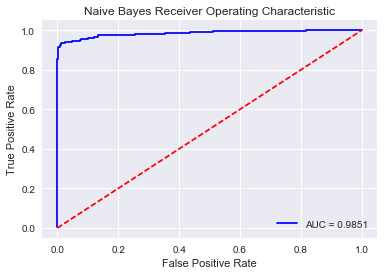

In [85]:
plt.title('Naive Bayes Receiver Operating Characteristic')
plt.plot(false_positive_rate_NB, true_positive_rate_NB, 'b',
label='AUC = %0.4f'% roc_auc_NB)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Our model gets a prediction accuracy of around 99%, which is very satisfying… 99% of the SMS tested were accurately predicted spam or ham

###  Random Forest Classifier

In [69]:
pipeline_RF = Pipeline([
    ('CV', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier(n_estimators = 100)),  # train on TF-IDF vectors w/ Random Forest classifier
])

In [70]:
Model_RF = pipeline_RF.fit(features_train,label_train)
Pred_RF = Model_RF.predict(features_test)
print classification_report(Pred_RF,label_test)
print pd.crosstab(label_test, Pred_RF, rownames=['Actual'], colnames=['Predicted'])

             precision    recall  f1-score   support

        ham       1.00      0.98      0.99      1476
       spam       0.84      0.99      0.91       196

avg / total       0.98      0.98      0.98      1672

Predicted   ham  spam
Actual               
ham        1440     1
spam         36   195


In [71]:
pred_prob_RF = Model_RF.predict_proba(features_test)[:, 1]
pred_prob_RF

array([ 0.02,  0.  ,  0.  , ...,  0.77,  0.07,  0.  ])

In [75]:
false_positive_rate_RF, true_positive_rate_RF, thresholds_RF = roc_curve(label_test_num, pred_prob_RF)
roc_auc_RF = auc(false_positive_rate_RF, true_positive_rate_RF)
print roc_auc_RF

0.984202588991


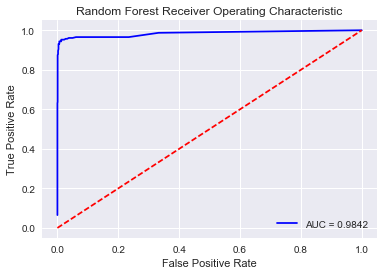

In [86]:
plt.title('Random Forest Receiver Operating Characteristic')
plt.plot(false_positive_rate_RF, true_positive_rate_RF, 'b',
label='AUC = %0.4f'% roc_auc_RF)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Support Vector Classifier

In [32]:
pipeline_SVM = Pipeline([
    ('CV', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC())  # train on TF-IDF vectors w/ Support vector classifier
])

params = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf', 'linear']},
]


grid_SVM = GridSearchCV(
    pipeline_SVM,  # pipeline from above
    param_grid=params,  # parameters to tune via cross validation
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [33]:
%time SVM_detector = grid_SVM.fit(features_train, label_train) # find the best combination from param_svm
print SVM_detector.grid_scores_

Wall time: 27min 46s
[mean: 0.86282, std: 0.00000, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.98308, std: 0.00297, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'linear', 'classifier__C': 1}, mean: 0.86282, std: 0.00000, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.98308, std: 0.00297, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'classifier__C': 1}, mean: 0.86282, std: 0.00000, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.98462, std: 0.00256, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'linear', 'classifier__C': 10}, mean: 0.86282, std: 0.00000, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.98462, std: 0.00256, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'classifier__C': 10}, mean: 0.95513, std: 0.00493, p

In [41]:
print confusion_matrix(label_test, SVM_detector.predict(features_test))
print pd.crosstab(label_test, SVM_detector.predict(features_test), rownames=['Actual'], colnames=['Predicted'])
print classification_report(label_test, SVM_detector.predict(features_test))

[[1457    3]
 [  21  191]]
Predicted   ham  spam
Actual               
ham        1457     3
spam         21   191
             precision    recall  f1-score   support

        ham       0.99      1.00      0.99      1460
       spam       0.98      0.90      0.94       212

avg / total       0.99      0.99      0.99      1672



## Step 6 : Sanity Check

In [83]:
print Model_NB.predict(["IMPORTANT - You could be entitled up to £3,160 in compensation from mis-sold PPI on a credit card or loan. Please reply PPI for info or STOP to opt out."])[0]
print Model_NB.predict(["A loan for £950 is approved for you if you receive this SMS. 1 min verification & cash in 1 hr at www.[redacted].co.uk to opt out reply stop"])[0]
print Model_NB.predict(["You have still not claimed the compensation you are due for the accident you had. To start the process please reply YES. To opt out text STOP"])[0]
print Model_NB.predict(["Due to a new legislation, those struggling with debt can now apply to have it written off. For more information text the word INFO or to opt out text STOP"])[0]
print Model_NB.predict(["Our records indicate your Pension is under performing to see higher growth and up to 25% cash release reply PENSION for a free review. To opt out reply STOP"])[0]

spam
spam
ham
spam
spam


In [84]:
print Model_RF.predict(["IMPORTANT - You could be entitled up to £3,160 in compensation from mis-sold PPI on a credit card or loan. Please reply PPI for info or STOP to opt out."])[0]
print Model_RF.predict(["A loan for £950 is approved for you if you receive this SMS. 1 min verification & cash in 1 hr at www.[redacted].co.uk to opt out reply stop"])[0]
print Model_RF.predict(["You have still not claimed the compensation you are due for the accident you had. To start the process please reply YES. To opt out text STOP"])[0]
print Model_RF.predict(["Due to a new legislation, those struggling with debt can now apply to have it written off. For more information text the word INFO or to opt out text STOP"])[0]
print Model_RF.predict(["Our records indicate your Pension is under performing to see higher growth and up to 25% cash release reply PENSION for a free review. To opt out reply STOP"])[0]

spam
spam
spam
spam
spam


Now I have a classification report for all the three models(Naive bayes, Support Vector classifier and Random Forest)and out of all the three, I got the best result with the support vector classifier with the accuracy, precision and recall value of 99% after tuning the parameters.But as we can see the total training time for SVC was 27min 46s which was comparatively high compared to the other two where it just took couple minutes to fit in the training examples. 